In [1]:
# importar las librerias necesarias
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from sklearn.metrics import mean_squared_error, mean_absolute_error
import sklearn.metrics as metrics

### Extraccion de Datos

- En esta etapa es importante cargar los datos, para este caso en especifico el formato es un csv, por ello hay que extraer la informacion mediante la funcion read_csv, tambien es importante indicar el tipo de delimitador.

In [2]:
# Cargar los datos requeridos en un dataframe
df_trn = pd.read_csv("C:\\Users\\francon\\Documents\\Zep\\data_test.csv", error_bad_lines=False, warn_bad_lines=False, encoding='latin-1',delimiter = ",")

In [3]:
# verificar que los datos fueron correctamente cargados al df
df_trn.head(3)

,PayerId,ReceiverId,invoiceId,paidAt,amount,amountfinancedByXepelin,status
0,53,10,18660729,2022-04-23 00:00:00,1490.46,0.00,PAID
1,93,11,18660730,2021-11-20 00:00:00,6418.28,624.48,PAID
2,122,12,18660731,2021-10-19 00:00:00,27979.20,10520.15,PAID


In [4]:
len(df_trn)

1200

### Limpieza de Datos

In [5]:
# identificar tipos de datos
df_trn.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1200 entries, 0 to 1199
Data columns (total 7 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   PayerId                  1200 non-null   int64  
 1   ReceiverId               1200 non-null   int64  
 2   invoiceId                1200 non-null   int64  
 3   paidAt                   892 non-null    object 
 4   amount                   1200 non-null   float64
 5   amountfinancedByXepelin  1200 non-null   float64
 6   status                   1200 non-null   object 
dtypes: float64(2), int64(3), object(2)
memory usage: 65.8+ KB


In [6]:
# identificar posibles valores de status
df_trn['status'].unique()

array(['PAID', 'PROCESSING', 'FAILED'], dtype=object)

In [7]:
# identificar los valores nulos de la fecha por estado
df_trn.groupby('status')['paidAt'].count()

status
FAILED          0
PAID          892
PROCESSING      0
Name: paidAt, dtype: int64

In [8]:
df_trn.groupby('status').count()

,PayerId,ReceiverId,invoiceId,paidAt,amount,amountfinancedByXepelin
status,,,,,,
FAILED,39,39,39,0,39,39
PAID,892,892,892,892,892,892
PROCESSING,269,269,269,0,269,269


Analizamos la informacion de cada variable del dataset y concluimos lo siguiente
- El dataset tiene 1200 datos.
- Las Variables PayerId, ReceiverId, invoicedId son variables que se refieren a los ids manejados en las transacciones, por ello se consideraria ignorarlo para este analisis.
- Esta informacion del dataset que estamos manejando muestra que tenemos datos nulos en la columna [paidAt] ademas podemos identificar que esta columna se refiere a la Fecha de pago, es necesario reformatear esta columna para convertirla en un tipo de dato (date) para facilitar el manejo de la informacion, respecto a las demas variables no cuenta con datos nulos.
- Tambien podemos apreciar que las fechas con datos nulos son las que el estado es FAILED o PROCESSING. <br><br>
Se puede considerar que las transacciones con estado Failed y Procesing no son parte del analisis ya que el objetivo es poder pronosticar el monto y estas transacciones no se realizaron por alguna razon o no terminaron el proceso de transaccion, en este tipo de casos es bueno indagar con las personas relacionadas al proyecto para evitar suposiciones.

In [9]:
# filtrar los clientes en estado failed y processing
df_trn=df_trn[df_trn['status']!='FAILED']
df_trn=df_trn[df_trn['status']!='PROCESSING']

In [10]:
df_trn.head(1)

,PayerId,ReceiverId,invoiceId,paidAt,amount,amountfinancedByXepelin,status
0,53,10,18660729,2022-04-23 00:00:00,1490.46,0.0,PAID


In [11]:
# modificar el tipo de dato de la columna paidAt
df_trn['paidAt'] = pd.to_datetime(df_trn['paidAt']).dt.date
df_trn['paidAt'] = pd.to_datetime(df_trn['paidAt'], format='%Y-%m-%d')

In [12]:
# eliminar las columnas consideradas secundarias para este analisis
df_trn=df_trn.drop(columns = ['PayerId','ReceiverId','invoiceId','status'])

In [13]:
# renombrar la columna [amountfinancedByXepelin] para que sea facil de manejar
df_trn=df_trn.rename(columns={'amountfinancedByXepelin':'amountFinanced'})

- Podemos revisar que los datos estan a nivel de transaccion, ya que hay dias en los cuales se tienen varias transacciones, y dias en los que no se tiene ninguna transaccion.
- El siguiente paso es poder convertir este dataset en una serie de tiempo.
- Se considera convertir el dataset a nivel de fechas [paidAt]

In [14]:
# convertir el dataset en una serie de tiempo
df_serie = df_trn.groupby("paidAt").sum()

In [15]:
df_serie.head(10)

,amount,amountFinanced
paidAt,,
2021-10-09,2410.72,0.00
2021-10-16,4035.26,0.00
2021-10-19,27979.20,10520.15
2021-10-31,1477.46,0.00
2021-11-02,8688.40,737.99
2021-11-13,183070.77,79421.63
2021-11-14,47181.52,34783.64
2021-11-15,526.26,0.00
2021-11-16,3758.92,0.00


Podemos revisar que los datos fueron convertidos en una serie de tiempo con las siguientes consideraciones
- La fecha es considerada como index.



Para manejar los casos de las fechas en los que no se tiene datos se puede tomar las siguientes estrategias:
- La fecha es considerada como index.
Para este caso se supondra que en estos dias no hubieron transacciones por ello no hay un monto de transaccion.
- La serie de tiempo es irregular ya que hay dias que se supone que no se tienen transacciones por lo tanto no hay montos asignados ni financiados, en este caso es bueno consultar al equipo a que se debe esta razon, se refiere a la perdida de datos o directamente en estos dias no hubieron transacciones.

### Analisis Exploratorio

Cuando se trabaja con series de tiempo es necesario identificar ciertas caracteristicas 
1. <b> Tendencia </b>:
2. <b> Estacionalidad </b>:
4. <b> Estacionaridad </b>:

A continuacion se analizara en funcion a la serie de tiempo:

#### Analisis de Monto

<b>Descomposicion de la serie de tiempo </b>

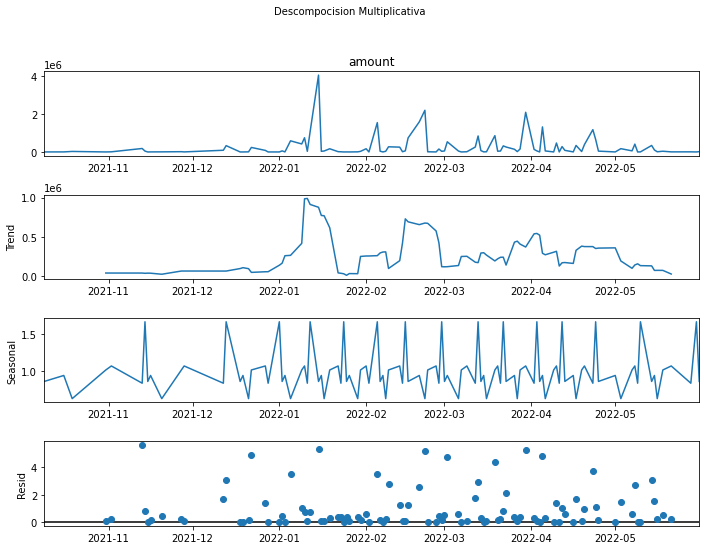

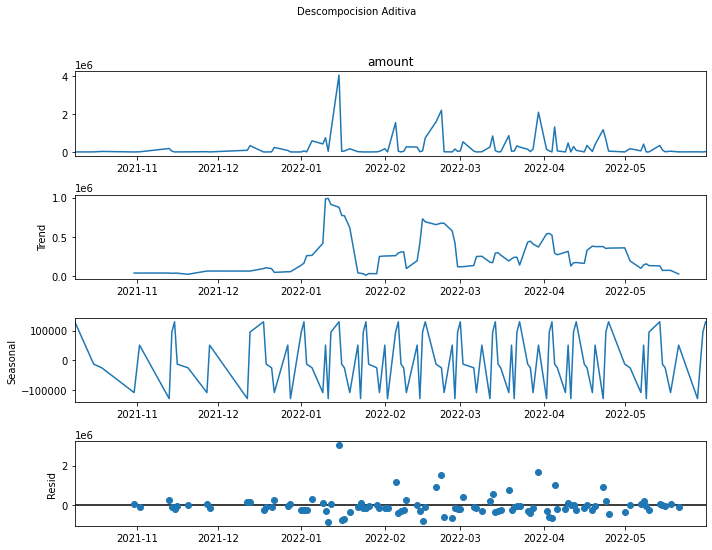

In [16]:
# descomposicion multiplicativa y de tipo adicion 
from statsmodels.tsa.seasonal import seasonal_decompose
from scipy.signal.signaltools import _centered
from dateutil.parser import parse

# Descompocision Multiplicativa
multiplicativa = seasonal_decompose(df_serie['amount'], model='multiplicative', period=7)

# Descompocision Aditiva
additiva = seasonal_decompose(df_serie['amount'], model='additive', period=7)

# Graficar
plt.rcParams.update({'figure.figsize': (10,8)})
multiplicativa.plot().suptitle('Descompocision Multiplicativa', fontsize=10)
plt.tight_layout(rect=[0, 0.03, 1, 0.95])

additiva.plot().suptitle('Descompocision Aditiva', fontsize=10)
plt.tight_layout(rect=[0, 0.03, 1, 0.95])

plt.show()

Las conclusiones que podemos sacar luego de generar la descomposicion de la serie : 
- La serie no tiente una tendencia definida
- La serie presenta una estacionalidad semanal

<b>Comprobacion de Estacionaridad </b>

<br>Para poder realizar un forecast de una serie de tiempo es necesario comprobar que la serie es estacionaria, en caso contrario se debe ejecutar una serie de pasos para hacer la conversion. </br>

Para comprobar la estacionaridad se aplica un test denominado  Dickey-Fuller 

In [17]:
import seaborn as sns
from statsmodels.tsa.stattools import adfuller
# aplicar el test de adfuller a la serie de tiempo
resultados_test = adfuller(df_serie["amount"])
# imprimir los resultados obtenidos del test
print(f"Test ADF: {resultados_test[0]}")
print(f"p-value: {resultados_test[1]}")
print("Thresholds:")
for key, value in resultados_test[4].items():
    print(f"\t{key}: {value}")

Test ADF: -8.58464113924497
p-value: 7.565012099578397e-14
Thresholds:
	1%: -3.4942202045135513
	5%: -2.889485291005291
	10%: -2.5816762131519275


El valor de p-value es menor a 0,05, por ello podemos suponer que la serie de tiempo es estacionaria

<b>Autocorrelacion ACF y Parcial Autocorrelacion PAF</b>

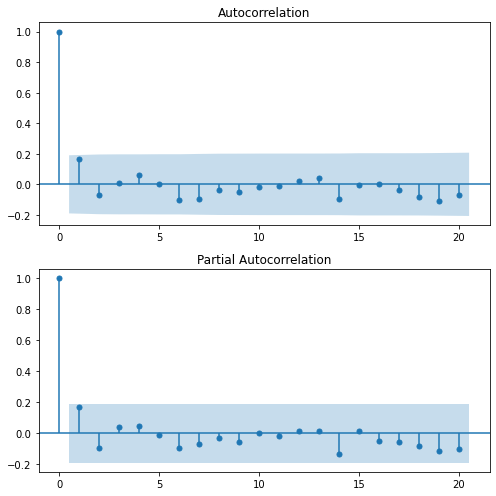

In [18]:
from statsmodels.tsa.stattools import acf, pacf
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

f, ax = plt.subplots(nrows=2, ncols=1, figsize=(7, 7))
plot_acf(df_serie['amount'],lags=20, ax=ax[0])
plot_pacf(df_serie['amount'],lags=20, ax=ax[1], method='ols')
plt.tight_layout()
plt.show()

#### Analisis de Monto Financiado

<b>Descomposicion de la serie de tiempo </b>

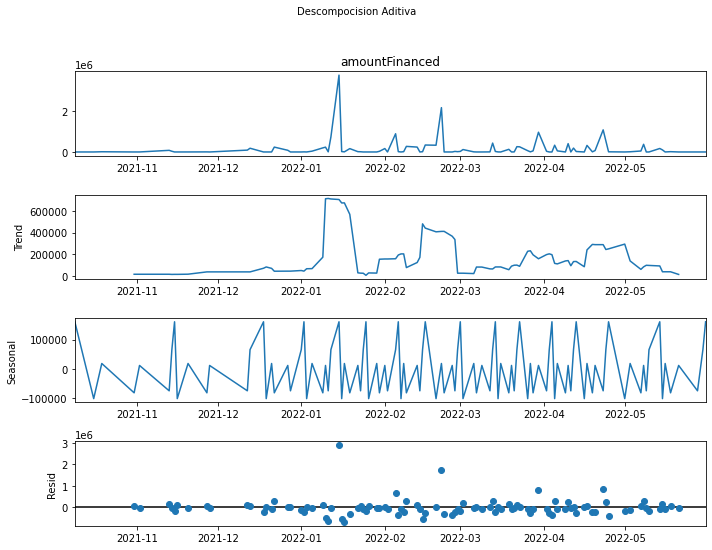

In [19]:
# descomposicion multiplicativa y de tipo adicion 
from statsmodels.tsa.seasonal import seasonal_decompose
from scipy.signal.signaltools import _centered
from dateutil.parser import parse

# Descompocision Aditiva
additiva = seasonal_decompose(df_serie['amountFinanced'], model='additive', period=7)

# Graficar
additiva.plot().suptitle('Descompocision Aditiva', fontsize=10)
plt.tight_layout(rect=[0, 0.03, 1, 0.95])

plt.show()

Las conclusiones que podemos sacar luego de generar la descomposicion de la serie : 
- La serie no tiente una tendencia definida
- La serie presenta una estacionalidad semanal

<b>Comprobacion de Estacionaridad </b>

<br>Para poder realizar un forecast de una serie de tiempo es necesario comprobar que la serie es estacionaria, en caso contrario se debe ejecutar una serie de pasos para hacer la conversion. </br>

Para comprobar la estacionaridad se aplica un test denominado  Dickey-Fuller 

In [20]:
import seaborn as sns
from statsmodels.tsa.stattools import adfuller
# aplicar el test de adfuller a la serie de tiempo
resultados_test = adfuller(df_serie["amountFinanced"])
# imprimir los resultados obtenidos del test
print(f"Test ADF: {resultados_test[0]}")
print(f"p-value: {resultados_test[1]}")
print("Thresholds:")
for key, value in resultados_test[4].items():
    print(f"\t{key}: {value}")

Test ADF: -9.182193673320096
p-value: 2.236365983790634e-15
Thresholds:
	1%: -3.4942202045135513
	5%: -2.889485291005291
	10%: -2.5816762131519275


El valor de p-value es menor a 0,05, por ello podemos suponer que la serie de tiempo es estacionaria

<b>Autocorrelacion ACF y Parcial Autocorrelacion PAF</b>

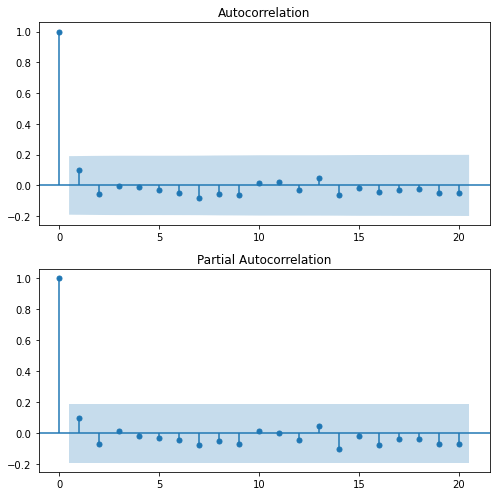

In [21]:
from statsmodels.tsa.stattools import acf, pacf
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

f, ax = plt.subplots(nrows=2, ncols=1, figsize=(7, 7))
plot_acf(df_serie['amountFinanced'],lags=20, ax=ax[0])
plot_pacf(df_serie['amountFinanced'],lags=20, ax=ax[1], method='ols')
plt.tight_layout()
plt.show()

#### Analisis de Monto

<b>Descomposicion de la serie de tiempo </b>

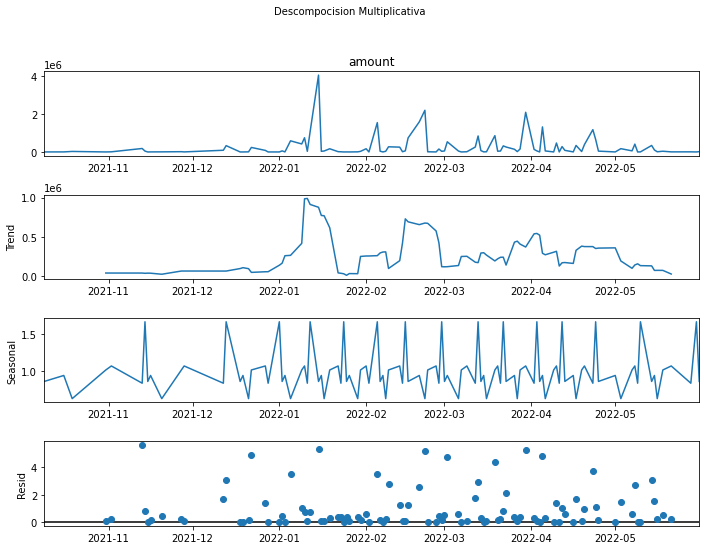

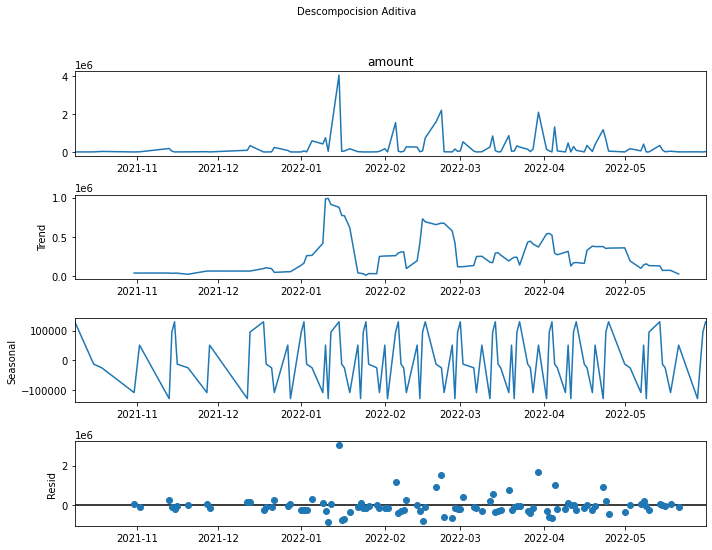

In [22]:
# descomposicion multiplicativa y de tipo adicion 
from statsmodels.tsa.seasonal import seasonal_decompose
from scipy.signal.signaltools import _centered
from dateutil.parser import parse

# Descompocision Multiplicativa
multiplicativa = seasonal_decompose(df_serie['amount'], model='multiplicative', period=7)

# Descompocision Aditiva
additiva = seasonal_decompose(df_serie['amount'], model='additive', period=7)

# Graficar
plt.rcParams.update({'figure.figsize': (10,8)})
multiplicativa.plot().suptitle('Descompocision Multiplicativa', fontsize=10)
plt.tight_layout(rect=[0, 0.03, 1, 0.95])

additiva.plot().suptitle('Descompocision Aditiva', fontsize=10)
plt.tight_layout(rect=[0, 0.03, 1, 0.95])

plt.show()

Las conclusiones que podemos sacar luego de generar la descomposicion de la serie : 
- La serie no tiente una tendencia definida
- La serie presenta una estacionalidad semanal

<b>Comprobacion de Estacionaridad </b>

<br>Para poder realizar un forecast de una serie de tiempo es necesario comprobar que la serie es estacionaria, en caso contrario se debe ejecutar una serie de pasos para hacer la conversion. </br>

Para comprobar la estacionaridad se aplica un test denominado  Dickey-Fuller 

In [23]:
import seaborn as sns
from statsmodels.tsa.stattools import adfuller
# aplicar el test de adfuller a la serie de tiempo
resultados_test = adfuller(df_serie["amount"])
# imprimir los resultados obtenidos del test
print(f"Test ADF: {resultados_test[0]}")
print(f"p-value: {resultados_test[1]}")
print("Thresholds:")
for key, value in resultados_test[4].items():
    print(f"\t{key}: {value}")

Test ADF: -8.58464113924497
p-value: 7.565012099578397e-14
Thresholds:
	1%: -3.4942202045135513
	5%: -2.889485291005291
	10%: -2.5816762131519275


El valor de p-value es menor a 0,05, por ello podemos suponer que la serie de tiempo es estacionaria

<b>Autocorrelacion ACF y Parcial Autocorrelacion PAF</b>

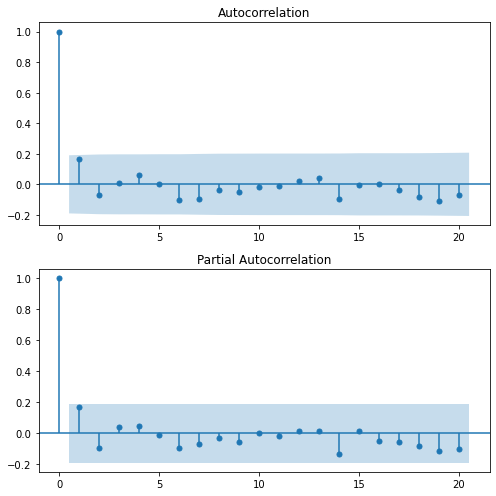

In [24]:
from statsmodels.tsa.stattools import acf, pacf
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

f, ax = plt.subplots(nrows=2, ncols=1, figsize=(7, 7))
plot_acf(df_serie['amount'],lags=20, ax=ax[0])
plot_pacf(df_serie['amount'],lags=20, ax=ax[1], method='ols')
plt.tight_layout()
plt.show()

### Planteamiento del Modelo

### Monto

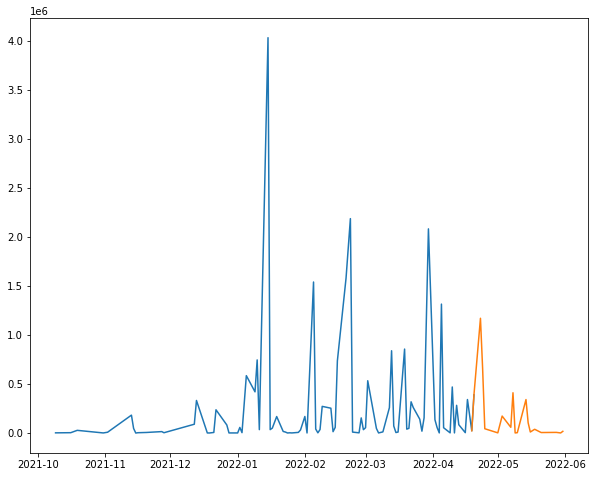

In [25]:
# particionar los datos de train y de test para el modelo
df_train = df_serie['amount'][:89]
df_test = df_serie['amount'][-19:]
plt.plot(df_train)
plt.plot(df_test)

#### AutoArima

In [26]:
from pmdarima import auto_arima
  
import warnings
warnings.filterwarnings("ignore")
  
arima_model = auto_arima(df_train,start_p = 0, start_q = 0,
                          max_p = 3, max_q = 3, m = 7,
                          start_P = 0, seasonal = True,
                          d = 1, D = 1, trace = True,
                          error_action ='ignore',  
                          suppress_warnings = True, 
                          stepwise = True)           
arima_model.summary()

Performing stepwise search to minimize aic
 ARIMA(0,1,0)(0,1,1)[7]             : AIC=2450.536, Time=0.17 sec
 ARIMA(0,1,0)(0,1,0)[7]             : AIC=2493.067, Time=0.01 sec
 ARIMA(1,1,0)(1,1,0)[7]             : AIC=2467.957, Time=0.07 sec
 ARIMA(0,1,1)(0,1,1)[7]             : AIC=2437.242, Time=0.06 sec
 ARIMA(0,1,1)(0,1,0)[7]             : AIC=inf, Time=0.05 sec
 ARIMA(0,1,1)(1,1,1)[7]             : AIC=2438.616, Time=0.17 sec
 ARIMA(0,1,1)(0,1,2)[7]             : AIC=2438.481, Time=0.28 sec
 ARIMA(0,1,1)(1,1,0)[7]             : AIC=2447.461, Time=0.07 sec
 ARIMA(0,1,1)(1,1,2)[7]             : AIC=2440.397, Time=0.42 sec
 ARIMA(1,1,1)(0,1,1)[7]             : AIC=2435.868, Time=0.08 sec
 ARIMA(1,1,1)(0,1,0)[7]             : AIC=inf, Time=0.08 sec
 ARIMA(1,1,1)(1,1,1)[7]             : AIC=2437.409, Time=0.14 sec
 ARIMA(1,1,1)(0,1,2)[7]             : AIC=2437.298, Time=0.15 sec
 ARIMA(1,1,1)(1,1,0)[7]             : AIC=2446.359, Time=0.12 sec
 ARIMA(1,1,1)(1,1,2)[7]             : AIC=2

<class 'statsmodels.iolib.summary.Summary'>
"""
                                     SARIMAX Results                                     
=========================================================================================
Dep. Variable:                                 y   No. Observations:                   89
Model:             SARIMAX(1, 1, 1)x(0, 1, 1, 7)   Log Likelihood               -1213.934
Date:                           Tue, 28 Jun 2022   AIC                           2435.868
Time:                                   10:15:30   BIC                           2445.445
Sample:                                        0   HQIC                          2439.710
                                            - 89                                         
Covariance Type:                             opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.1485      0.229      0.649      0.516      -0.300       0.597
ma.L1         -0.9324      0.213     -4.384      0.000      -1.349      -0.516
ma.S.L7       -0.7996      0.242     -3.303      0.001      -1.274      -0.325
sigma2      9.962e+11   1.58e-13    6.3e+24      0.000    9.96e+11    9.96e+11
===================================================================================
Ljung-Box (L1) (Q):                   0.01   Jarque-Bera (JB):               382.42
Prob(Q):                              0.93   Prob(JB):                         0.00
Heteroskedasticity (H):               0.50   Skew:                             2.47
Prob(H) (two-sided):                  0.08   Kurtosis:                        12.43
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
[2] Covariance matrix is singular or near-singular, with condition number 2.05e+40. Standard errors may be unstable.
"""

In [27]:
predic_val = pd.DataFrame(arima_model.predict(n_periods=19), index=df_test.index)
predic_val.columns = ['amount_Pred']
predic_val

,amount_Pred
paidAt,
2022-04-19,56322.188524
2022-04-20,327477.796458
2022-04-23,259670.671306
2022-04-24,380286.318485
2022-04-25,251044.102134
2022-05-01,152735.747849
2022-05-03,471792.980880
2022-05-07,70417.921163
2022-05-08,331563.364683


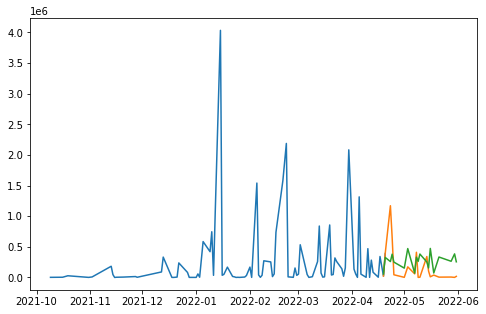

In [28]:
plt.figure(figsize=(8,5))
plt.plot(df_train,label="Training")
plt.plot(df_test,label="Test")
plt.plot(predic_val,label="Predicted")

#Graficar los montos reales y los que se predecidos
plt.show()

In [29]:
df_test.values

array([  23674.68,  390300.74, 1171308.8 ,  657567.27,   44358.7 ,
          2395.72,  173554.56,   59157.1 ,  411390.32,    1490.26,
          4077.98,  341978.06,  104623.1 ,   11004.22,   38941.18,
          5612.18,    7061.7 ,    1490.46,   18011.78])

In [30]:
predic_val['amount_Pred'].values

array([ 56322.18852352, 327477.79645785, 259670.67130567, 380286.31848497,
       251044.1021344 , 152735.7478487 , 471792.98088036,  70417.92116278,
       331563.36468273, 262269.46530118, 382664.28717555, 253389.27242537,
       155076.04670967, 474132.5562051 ,  72757.38902326, 333902.81658192,
       264608.91482969, 385003.73635195, 255728.72154948])

In [31]:
mae = metrics.mean_absolute_error(df_test.values, predic_val['amount_Pred'].values)
mse = metrics.mean_squared_error(df_test.values, predic_val['amount_Pred'].values)
rmse = np.sqrt(mse) 
r2 = metrics.r2_score(df_test.values, predic_val['amount_Pred'])

print("Metricas:")
print("MAE:",mae)
print("MSE:", mse)
print("RMSE:", rmse)
print("R-Squared:", r2)

Metricas:
MAE: 237534.79057478698
MSE: 99410684631.14131
RMSE: 315294.59974941105
R-Squared: -0.1384854473946331


In [32]:
# prediccion futuras
pred = arima_model.predict(start = len(df_serie), end = (df_serie)+60, typ='levels')

In [33]:
# crear el indice para los valores
index_fdates = pd.date_range(start='2022-04-19', end='2022-06-30')

In [34]:
predic_val = pd.DataFrame(arima_model.predict(n_periods=73), index=index_fdates)
predic_val.columns = ['amount_Pred']
predic_val

,amount_Pred
2022-04-19,56322.188524
2022-04-20,327477.796458
2022-04-21,259670.671306
2022-04-22,380286.318485
2022-04-23,251044.102134
...,...
2022-06-26,173791.639631
2022-06-27,492848.149125
2022-06-28,91472.981943
2022-06-29,352618.409502


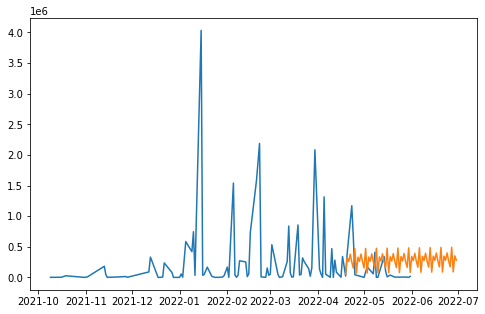

In [35]:
plt.figure(figsize=(8,5))
plt.plot(df_serie['amount'],label="Real")
plt.plot(predic_val,label="Pred")


#Graficar los montos reales y los que se predecidos
plt.show()

<AxesSubplot:>

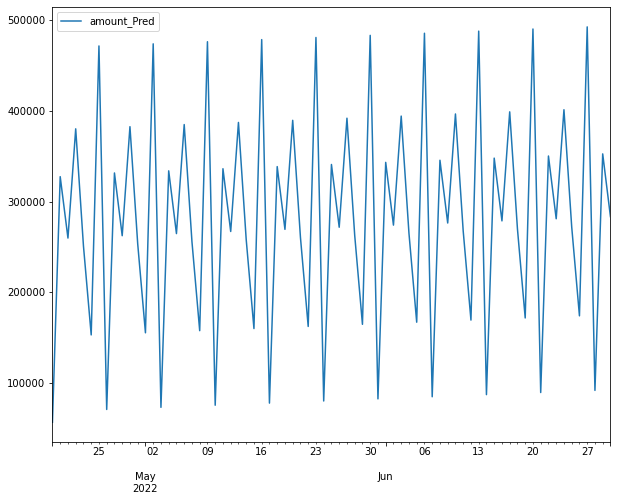

In [36]:
predic_val.plot()

A traves de ARIMA podemos ver que la prediccion es poco precisa por ello se recomienda tener mas cantidad de datos para mejorar el performance, tambien analizar como manejar esos valores en los que algunos dias no se tiene transacciones, aplicar otro modelo que se ajuste de manera mas adecuada.

#### XGBoost

In [37]:
from xgboost import XGBRegressor
import xgboost as xgb


In [38]:
# dividir los datos para train y test
def split_data(data, split_date):
    return data[data.index <= split_date].copy(), \
           data[data.index >  split_date].copy()
train, test = split_data(df_serie, '2022-04-20')

In [39]:
# eliminar la columna de monto financiado
test = test.drop(columns = 'amountFinanced')
train = train.drop(columns = 'amountFinanced')

In [40]:
def descomposicion_fechas(df):
    """
    Crea las descompocision de la fecha
    """
    df['date'] = df.index
    df['dayofweek'] = pd.DatetimeIndex(df['date']).dayofweek
    df['quarter'] = pd.DatetimeIndex(df['date']).quarter
    df['month'] = pd.DatetimeIndex(df['date']).month
    df['year'] = pd.DatetimeIndex(df['date']).year
    df['dayofyear'] = pd.DatetimeIndex(df['date']).dayofyear
    df['dayofmonth'] = pd.DatetimeIndex(df['date']).day
    df['weekofyear'] = pd.DatetimeIndex(df['date']).weekofyear
    
    X = df[['dayofweek','quarter','month','year',
           'dayofyear','dayofmonth','weekofyear']]
    return X

In [41]:
X_train, y_train = descomposicion_fechas(train), train['amount']
X_test, y_test   = descomposicion_fechas(test), test['amount']
X_train.shape, y_train.shape

((89, 7), (89,))

In [42]:
# ajustar el modelo XGBoost
reg = xgb.XGBRegressor(objective='reg:squarederror',n_estimators=1000)
reg.fit(X_train, y_train)

XGBRegressor(base_score=0.5, booster='gbtree', callbacks=None,
             colsample_bylevel=1, colsample_bynode=1, colsample_bytree=1,
             early_stopping_rounds=None, enable_categorical=False,
             eval_metric=None, gamma=0, gpu_id=-1, grow_policy='depthwise',
             importance_type=None, interaction_constraints='',
             learning_rate=0.300000012, max_bin=256, max_cat_to_onehot=4,
             max_delta_step=0, max_depth=6, max_leaves=0, min_child_weight=1,
             missing=nan, monotone_constraints='()', n_estimators=1000,
             n_jobs=0, num_parallel_tree=1, predictor='auto', random_state=0,
             reg_alpha=0, reg_lambda=1, ...)

<AxesSubplot:title={'center':'Feature importance'}, xlabel='F score', ylabel='Features'>

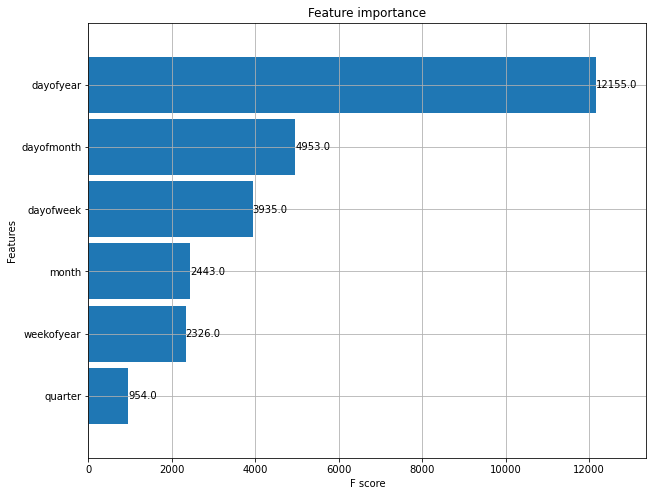

In [43]:
# variables importantes para el regresor
xgb.plot_importance(reg, height=0.9)

In [44]:
X_test_pred = reg.predict(X_test)

In [45]:
# calcular el error
mean_squared_error(y_true=y_test,
                   y_pred=X_test_pred)

283414422527.5651

In [46]:
# calcular el error absoluto
mean_absolute_error(y_true=y_test,
                   y_pred=X_test_pred)

366570.0929595588

Lo que podemos ver de igual manera que usando ARIMA se puede notar que es poco preciso pero mejor que AutoArima sin embargo para optimizar el modelo se tomaria las siguientes consideraciones:

- Utilizar mas datos para mejorar el performance
- Utilizar variables exogenas que permitan ayudar o identificar cierto patron que mejore el accuracy
- Utilizar hiperparametros para ayudar a mejorar al modelo
- Utilizar tecnicas como GridSearch.

### Monto Financiado

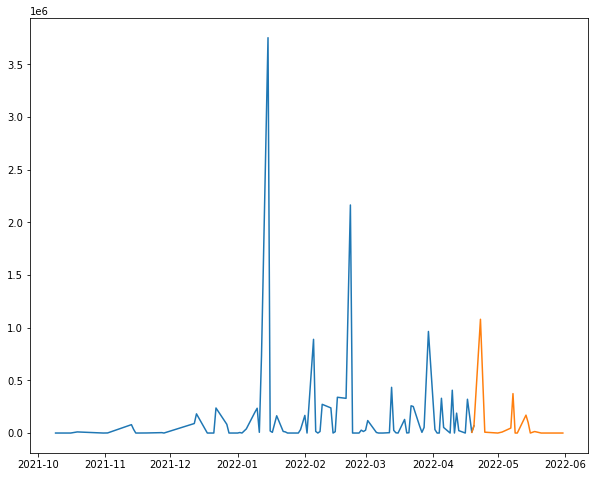

In [47]:
# particionar los datos de train y de test para el modelo
df_train = df_serie['amountFinanced'][:89]
df_test = df_serie['amountFinanced'][-19:]
plt.plot(df_train)
plt.plot(df_test)

#### AutoArima

In [48]:
from pmdarima import auto_arima
  
import warnings
warnings.filterwarnings("ignore")
  
arima_model = auto_arima(df_train,start_p = 0, start_q = 0,
                          max_p = 3, max_q = 3, m = 7,
                          start_P = 0, seasonal = True,
                          d = 1, D = 1, trace = True,
                          error_action ='ignore',  
                          suppress_warnings = True, 
                          stepwise = True)           
arima_model.summary()

Performing stepwise search to minimize aic
 ARIMA(0,1,0)(0,1,1)[7]             : AIC=inf, Time=0.12 sec
 ARIMA(0,1,0)(0,1,0)[7]             : AIC=2462.573, Time=0.02 sec
 ARIMA(1,1,0)(1,1,0)[7]             : AIC=2431.522, Time=0.07 sec
 ARIMA(0,1,1)(0,1,1)[7]             : AIC=2402.228, Time=0.09 sec
 ARIMA(0,1,1)(0,1,0)[7]             : AIC=inf, Time=0.07 sec
 ARIMA(0,1,1)(1,1,1)[7]             : AIC=2403.837, Time=0.12 sec
 ARIMA(0,1,1)(0,1,2)[7]             : AIC=2403.799, Time=0.18 sec
 ARIMA(0,1,1)(1,1,0)[7]             : AIC=2411.550, Time=0.11 sec
 ARIMA(0,1,1)(1,1,2)[7]             : AIC=2405.752, Time=0.43 sec
 ARIMA(1,1,1)(0,1,1)[7]             : AIC=2403.465, Time=0.09 sec
 ARIMA(0,1,2)(0,1,1)[7]             : AIC=2404.744, Time=0.12 sec
 ARIMA(1,1,0)(0,1,1)[7]             : AIC=2418.187, Time=0.09 sec
 ARIMA(1,1,2)(0,1,1)[7]             : AIC=2405.478, Time=0.36 sec
 ARIMA(0,1,1)(0,1,1)[7] intercept   : AIC=2404.704, Time=0.09 sec

Best model:  ARIMA(0,1,1)(0,1,1)[7]       

<class 'statsmodels.iolib.summary.Summary'>
"""
                                     SARIMAX Results                                     
=========================================================================================
Dep. Variable:                                 y   No. Observations:                   89
Model:             SARIMAX(0, 1, 1)x(0, 1, 1, 7)   Log Likelihood               -1198.114
Date:                           Tue, 28 Jun 2022   AIC                           2402.228
Time:                                   10:15:39   BIC                           2409.411
Sample:                                        0   HQIC                          2405.110
                                            - 89                                         
Covariance Type:                             opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ma.L1         -0.9177      0.220     -4.176      0.000      -1.348      -0.487
ma.S.L7       -0.8035      0.160     -5.021      0.000      -1.117      -0.490
sigma2      6.869e+11   2.54e-13   2.71e+24      0.000    6.87e+11    6.87e+11
===================================================================================
Ljung-Box (L1) (Q):                   0.58   Jarque-Bera (JB):              1883.93
Prob(Q):                              0.45   Prob(JB):                         0.00
Heteroskedasticity (H):               0.13   Skew:                             3.99
Prob(H) (two-sided):                  0.00   Kurtosis:                        25.24
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
[2] Covariance matrix is singular or near-singular, with condition number 2.74e+40. Standard errors may be unstable.
"""

In [49]:
predic_val = pd.DataFrame(arima_model.predict(n_periods=19), index=df_test.index)
predic_val.columns = ['amount_Pred']
predic_val

,amount_Pred
paidAt,
2022-04-19,-18203.419556
2022-04-20,169953.985265
2022-04-23,176227.410327
2022-04-24,64254.953660
2022-04-25,192559.608854
2022-05-01,27397.706419
2022-05-03,203156.367408
2022-05-07,-21767.343257
2022-05-08,166390.061564


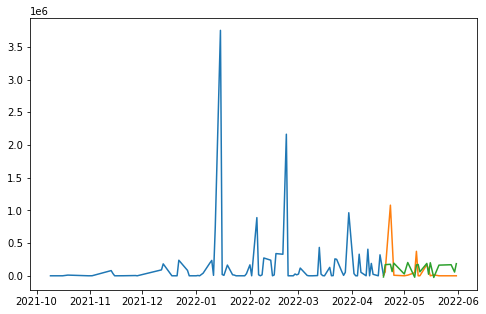

In [50]:
plt.figure(figsize=(8,5))
plt.plot(df_train,label="Training")
plt.plot(df_test,label="Test")
plt.plot(predic_val,label="Predicted")

#Graficar los montos reales y los que se predecidos
plt.show()

In [51]:
df_test.values

array([   6504.48,   68609.18, 1079751.14,  540023.98,    8024.41,
             0.  ,    9529.61,   47030.  ,  374279.37,       0.  ,
             0.  ,  169913.1 ,   99721.72,       0.  ,   14261.97,
             0.  ,       0.  ,       0.  ,       0.  ])

In [52]:
predic_val['amount_Pred'].values

array([-18203.41955636, 169953.98526495, 176227.41032659,  64254.95365969,
       192559.6088541 ,  27397.70641934, 203156.36740769, -21767.34325703,
       166390.06156428, 172663.48662592,  60691.02995901, 188995.68515343,
        23833.78271867, 199592.44370702, -25331.2669577 , 162826.1378636 ,
       169099.56292524,  57127.10625834, 185431.76145275])

In [53]:
mae = metrics.mean_absolute_error(df_test.values, predic_val['amount_Pred'].values)
mse = metrics.mean_squared_error(df_test.values, predic_val['amount_Pred'].values)
rmse = np.sqrt(mse) 
r2 = metrics.r2_score(df_test.values, predic_val['amount_Pred'])

print("Metricas:")
print("MAE:",mae)
print("MSE:", mse)
print("RMSE:", rmse)
print("R-Squared:", r2)

Metricas:
MAE: 175241.42438911932
MSE: 70927274266.78514
RMSE: 266321.7495188576
R-Squared: -0.008639388701311868


In [54]:
# prediccion futuras
pred = arima_model.predict(start = len(df_serie), end = (df_serie)+60, typ='levels')

In [55]:
# crear el indice para los valores
index_fdates = pd.date_range(start='2022-04-19', end='2022-06-30')

In [56]:
predic_val = pd.DataFrame(arima_model.predict(n_periods=73), index=index_fdates)
predic_val.columns = ['amount_Pred']
predic_val

,amount_Pred
2022-04-19,-18203.419556
2022-04-20,169953.985265
2022-04-21,176227.410327
2022-04-22,64254.953660
2022-04-23,192559.608854
...,...
2022-06-26,-4677.606887
2022-06-27,171081.054102
2022-06-28,-53842.656563
2022-06-29,134314.748258


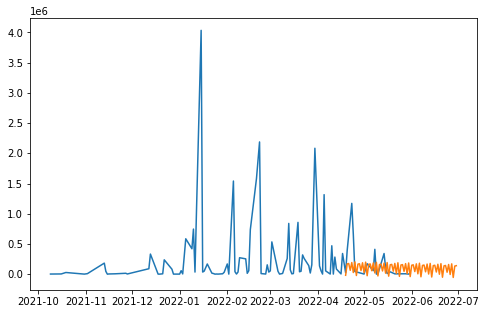

In [57]:
plt.figure(figsize=(8,5))
plt.plot(df_serie['amount'],label="Real")
plt.plot(predic_val,label="Pred")


#Graficar los montos reales y los que se predecidos
plt.show()

<AxesSubplot:>

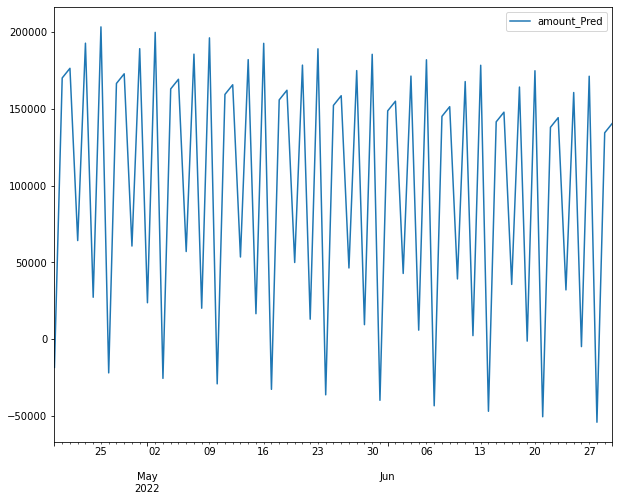

In [58]:
predic_val.plot()

A traves de ARIMA podemos ver que la prediccion es poco precisa por ello se recomienda tener mas cantidad de datos para mejorar el performance, tambien analizar como manejar esos valores en los que algunos dias no se tiene transacciones, aplicar otro modelo que se ajuste de manera mas adecuada.

In [1]:
# importar las librerias necesarias
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from sklearn.metrics import mean_squared_error, mean_absolute_error
import sklearn.metrics as metrics

### Extraccion de Datos

- En esta etapa es importante cargar los datos, para este caso en especifico el formato es un csv, por ello hay que extraer la informacion mediante la funcion read_csv, tambien es importante indicar el tipo de delimitador.

In [2]:
# Cargar los datos requeridos en un dataframe
df_trn = pd.read_csv("C:\\Users\\francon\\Documents\\Zep\\data_test.csv", error_bad_lines=False, warn_bad_lines=False, encoding='latin-1',delimiter = ",")

In [3]:
# verificar que los datos fueron correctamente cargados al df
df_trn.head(3)

,PayerId,ReceiverId,invoiceId,paidAt,amount,amountfinancedByXepelin,status
0,53,10,18660729,2022-04-23 00:00:00,1490.46,0.00,PAID
1,93,11,18660730,2021-11-20 00:00:00,6418.28,624.48,PAID
2,122,12,18660731,2021-10-19 00:00:00,27979.20,10520.15,PAID


In [4]:
len(df_trn)

1200

### Limpieza de Datos

In [5]:
# identificar tipos de datos
df_trn.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1200 entries, 0 to 1199
Data columns (total 7 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   PayerId                  1200 non-null   int64  
 1   ReceiverId               1200 non-null   int64  
 2   invoiceId                1200 non-null   int64  
 3   paidAt                   892 non-null    object 
 4   amount                   1200 non-null   float64
 5   amountfinancedByXepelin  1200 non-null   float64
 6   status                   1200 non-null   object 
dtypes: float64(2), int64(3), object(2)
memory usage: 65.8+ KB


In [6]:
# identificar posibles valores de status
df_trn['status'].unique()

array(['PAID', 'PROCESSING', 'FAILED'], dtype=object)

In [7]:
# identificar los valores nulos de la fecha por estado
df_trn.groupby('status')['paidAt'].count()

status
FAILED          0
PAID          892
PROCESSING      0
Name: paidAt, dtype: int64

In [8]:
df_trn.groupby('status').count()

,PayerId,ReceiverId,invoiceId,paidAt,amount,amountfinancedByXepelin
status,,,,,,
FAILED,39,39,39,0,39,39
PAID,892,892,892,892,892,892
PROCESSING,269,269,269,0,269,269


Analizamos la informacion de cada variable del dataset y concluimos lo siguiente
- El dataset tiene 1200 datos.
- Las Variables PayerId, ReceiverId, invoicedId son variables que se refieren a los ids manejados en las transacciones, por ello se consideraria ignorarlo para este analisis.
- Esta informacion del dataset que estamos manejando muestra que tenemos datos nulos en la columna [paidAt] ademas podemos identificar que esta columna se refiere a la Fecha de pago, es necesario reformatear esta columna para convertirla en un tipo de dato (date) para facilitar el manejo de la informacion, respecto a las demas variables no cuenta con datos nulos.
- Tambien podemos apreciar que las fechas con datos nulos son las que el estado es FAILED o PROCESSING. <br><br>
Se puede considerar que las transacciones con estado Failed y Procesing no son parte del analisis ya que el objetivo es poder pronosticar el monto y estas transacciones no se realizaron por alguna razon o no terminaron el proceso de transaccion, en este tipo de casos es bueno indagar con las personas relacionadas al proyecto para evitar suposiciones.

In [9]:
# filtrar los clientes en estado failed y processing
df_trn=df_trn[df_trn['status']!='FAILED']
df_trn=df_trn[df_trn['status']!='PROCESSING']

In [10]:
df_trn.head(1)

,PayerId,ReceiverId,invoiceId,paidAt,amount,amountfinancedByXepelin,status
0,53,10,18660729,2022-04-23 00:00:00,1490.46,0.0,PAID


In [11]:
# modificar el tipo de dato de la columna paidAt
df_trn['paidAt'] = pd.to_datetime(df_trn['paidAt']).dt.date
df_trn['paidAt'] = pd.to_datetime(df_trn['paidAt'], format='%Y-%m-%d')

In [12]:
# eliminar las columnas consideradas secundarias para este analisis
df_trn=df_trn.drop(columns = ['PayerId','ReceiverId','invoiceId','status'])

In [13]:
# renombrar la columna [amountfinancedByXepelin] para que sea facil de manejar
df_trn=df_trn.rename(columns={'amountfinancedByXepelin':'amountFinanced'})

- Podemos revisar que los datos estan a nivel de transaccion, ya que hay dias en los cuales se tienen varias transacciones, y dias en los que no se tiene ninguna transaccion.
- El siguiente paso es poder convertir este dataset en una serie de tiempo.
- Se considera convertir el dataset a nivel de fechas [paidAt]

In [14]:
# convertir el dataset en una serie de tiempo
df_serie = df_trn.groupby("paidAt").sum()

In [15]:
df_serie.head(10)

,amount,amountFinanced
paidAt,,
2021-10-09,2410.72,0.00
2021-10-16,4035.26,0.00
2021-10-19,27979.20,10520.15
2021-10-31,1477.46,0.00
2021-11-02,8688.40,737.99
2021-11-13,183070.77,79421.63
2021-11-14,47181.52,34783.64
2021-11-15,526.26,0.00
2021-11-16,3758.92,0.00


Podemos revisar que los datos fueron convertidos en una serie de tiempo con las siguientes consideraciones
- La fecha es considerada como index.



Para manejar los casos de las fechas en los que no se tiene datos se puede tomar las siguientes estrategias:
- La fecha es considerada como index.
Para este caso se supondra que en estos dias no hubieron transacciones por ello no hay un monto de transaccion.
- La serie de tiempo es irregular ya que hay dias que se supone que no se tienen transacciones por lo tanto no hay montos asignados ni financiados, en este caso es bueno consultar al equipo a que se debe esta razon, se refiere a la perdida de datos o directamente en estos dias no hubieron transacciones.

### Analisis Exploratorio

Cuando se trabaja con series de tiempo es necesario identificar ciertas caracteristicas 
1. <b> Tendencia </b>:
2. <b> Estacionalidad </b>:
4. <b> Estacionaridad </b>:

A continuacion se analizara en funcion a la serie de tiempo:

#### Analisis de Monto

<b>Descomposicion de la serie de tiempo </b>

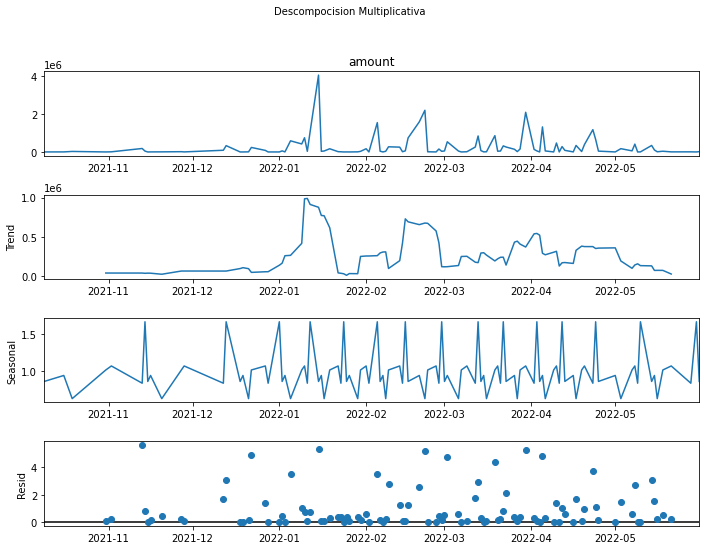

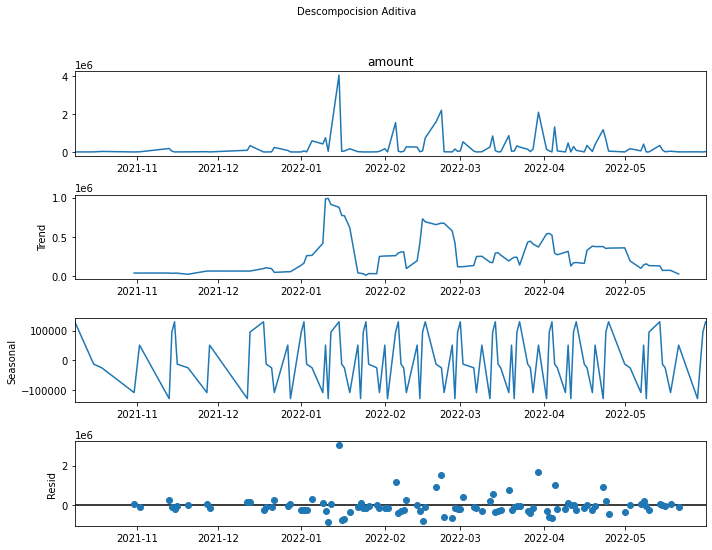

In [16]:
# descomposicion multiplicativa y de tipo adicion 
from statsmodels.tsa.seasonal import seasonal_decompose
from scipy.signal.signaltools import _centered
from dateutil.parser import parse

# Descompocision Multiplicativa
multiplicativa = seasonal_decompose(df_serie['amount'], model='multiplicative', period=7)

# Descompocision Aditiva
additiva = seasonal_decompose(df_serie['amount'], model='additive', period=7)

# Graficar
plt.rcParams.update({'figure.figsize': (10,8)})
multiplicativa.plot().suptitle('Descompocision Multiplicativa', fontsize=10)
plt.tight_layout(rect=[0, 0.03, 1, 0.95])

additiva.plot().suptitle('Descompocision Aditiva', fontsize=10)
plt.tight_layout(rect=[0, 0.03, 1, 0.95])

plt.show()

Las conclusiones que podemos sacar luego de generar la descomposicion de la serie : 
- La serie no tiente una tendencia definida
- La serie presenta una estacionalidad semanal

<b>Comprobacion de Estacionaridad </b>

<br>Para poder realizar un forecast de una serie de tiempo es necesario comprobar que la serie es estacionaria, en caso contrario se debe ejecutar una serie de pasos para hacer la conversion. </br>

Para comprobar la estacionaridad se aplica un test denominado  Dickey-Fuller 

In [17]:
import seaborn as sns
from statsmodels.tsa.stattools import adfuller
# aplicar el test de adfuller a la serie de tiempo
resultados_test = adfuller(df_serie["amount"])
# imprimir los resultados obtenidos del test
print(f"Test ADF: {resultados_test[0]}")
print(f"p-value: {resultados_test[1]}")
print("Thresholds:")
for key, value in resultados_test[4].items():
    print(f"\t{key}: {value}")

Test ADF: -8.58464113924497
p-value: 7.565012099578397e-14
Thresholds:
	1%: -3.4942202045135513
	5%: -2.889485291005291
	10%: -2.5816762131519275


El valor de p-value es menor a 0,05, por ello podemos suponer que la serie de tiempo es estacionaria

<b>Autocorrelacion ACF y Parcial Autocorrelacion PAF</b>

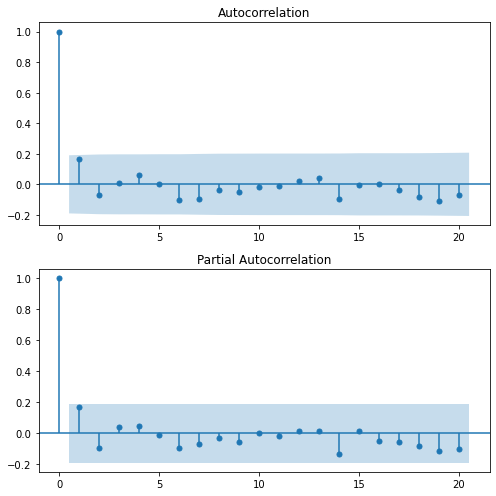

In [18]:
from statsmodels.tsa.stattools import acf, pacf
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

f, ax = plt.subplots(nrows=2, ncols=1, figsize=(7, 7))
plot_acf(df_serie['amount'],lags=20, ax=ax[0])
plot_pacf(df_serie['amount'],lags=20, ax=ax[1], method='ols')
plt.tight_layout()
plt.show()

#### Analisis de Monto Financiado

<b>Descomposicion de la serie de tiempo </b>

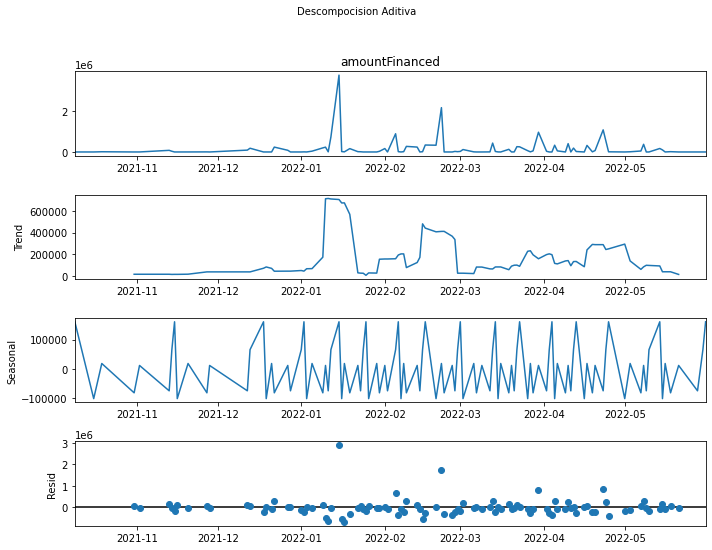

In [19]:
# descomposicion multiplicativa y de tipo adicion 
from statsmodels.tsa.seasonal import seasonal_decompose
from scipy.signal.signaltools import _centered
from dateutil.parser import parse

# Descompocision Aditiva
additiva = seasonal_decompose(df_serie['amountFinanced'], model='additive', period=7)

# Graficar
additiva.plot().suptitle('Descompocision Aditiva', fontsize=10)
plt.tight_layout(rect=[0, 0.03, 1, 0.95])

plt.show()

Las conclusiones que podemos sacar luego de generar la descomposicion de la serie : 
- La serie no tiente una tendencia definida
- La serie presenta una estacionalidad semanal

<b>Comprobacion de Estacionaridad </b>

<br>Para poder realizar un forecast de una serie de tiempo es necesario comprobar que la serie es estacionaria, en caso contrario se debe ejecutar una serie de pasos para hacer la conversion. </br>

Para comprobar la estacionaridad se aplica un test denominado  Dickey-Fuller 

In [20]:
import seaborn as sns
from statsmodels.tsa.stattools import adfuller
# aplicar el test de adfuller a la serie de tiempo
resultados_test = adfuller(df_serie["amountFinanced"])
# imprimir los resultados obtenidos del test
print(f"Test ADF: {resultados_test[0]}")
print(f"p-value: {resultados_test[1]}")
print("Thresholds:")
for key, value in resultados_test[4].items():
    print(f"\t{key}: {value}")

Test ADF: -9.182193673320096
p-value: 2.236365983790634e-15
Thresholds:
	1%: -3.4942202045135513
	5%: -2.889485291005291
	10%: -2.5816762131519275


El valor de p-value es menor a 0,05, por ello podemos suponer que la serie de tiempo es estacionaria

<b>Autocorrelacion ACF y Parcial Autocorrelacion PAF</b>

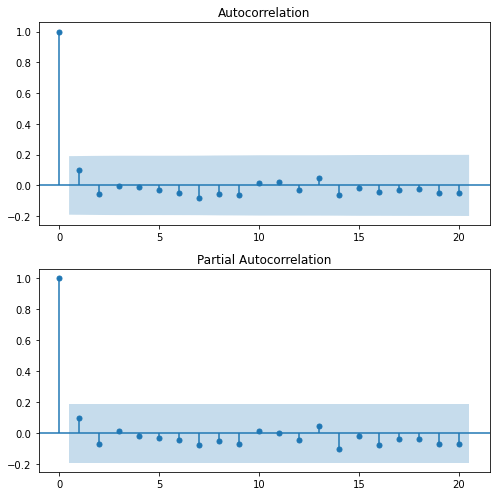

In [21]:
from statsmodels.tsa.stattools import acf, pacf
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

f, ax = plt.subplots(nrows=2, ncols=1, figsize=(7, 7))
plot_acf(df_serie['amountFinanced'],lags=20, ax=ax[0])
plot_pacf(df_serie['amountFinanced'],lags=20, ax=ax[1], method='ols')
plt.tight_layout()
plt.show()

#### Analisis de Monto

<b>Descomposicion de la serie de tiempo </b>

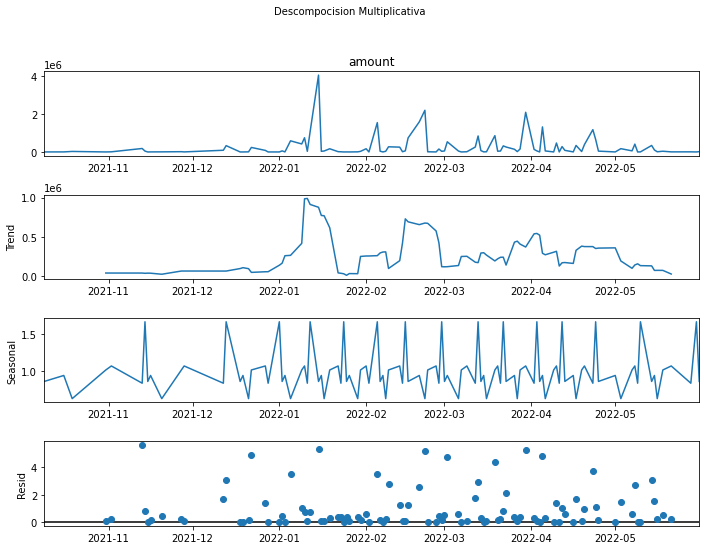

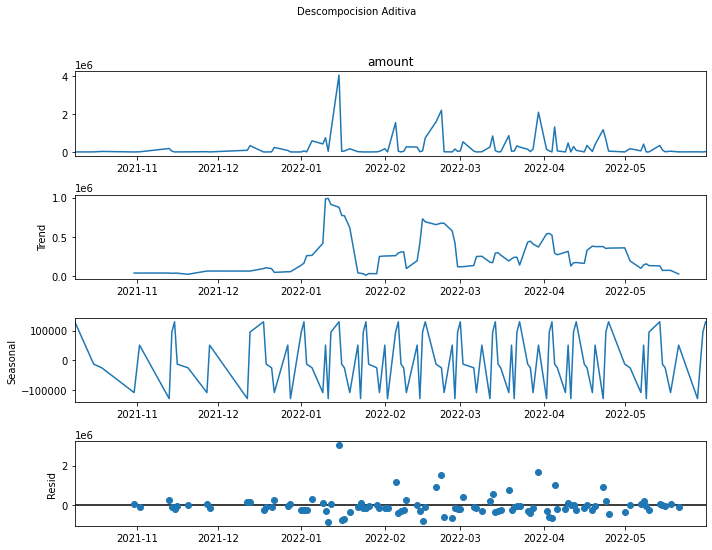

In [22]:
# descomposicion multiplicativa y de tipo adicion 
from statsmodels.tsa.seasonal import seasonal_decompose
from scipy.signal.signaltools import _centered
from dateutil.parser import parse

# Descompocision Multiplicativa
multiplicativa = seasonal_decompose(df_serie['amount'], model='multiplicative', period=7)

# Descompocision Aditiva
additiva = seasonal_decompose(df_serie['amount'], model='additive', period=7)

# Graficar
plt.rcParams.update({'figure.figsize': (10,8)})
multiplicativa.plot().suptitle('Descompocision Multiplicativa', fontsize=10)
plt.tight_layout(rect=[0, 0.03, 1, 0.95])

additiva.plot().suptitle('Descompocision Aditiva', fontsize=10)
plt.tight_layout(rect=[0, 0.03, 1, 0.95])

plt.show()

Las conclusiones que podemos sacar luego de generar la descomposicion de la serie : 
- La serie no tiente una tendencia definida
- La serie presenta una estacionalidad semanal

<b>Comprobacion de Estacionaridad </b>

<br>Para poder realizar un forecast de una serie de tiempo es necesario comprobar que la serie es estacionaria, en caso contrario se debe ejecutar una serie de pasos para hacer la conversion. </br>

Para comprobar la estacionaridad se aplica un test denominado  Dickey-Fuller 

In [23]:
import seaborn as sns
from statsmodels.tsa.stattools import adfuller
# aplicar el test de adfuller a la serie de tiempo
resultados_test = adfuller(df_serie["amount"])
# imprimir los resultados obtenidos del test
print(f"Test ADF: {resultados_test[0]}")
print(f"p-value: {resultados_test[1]}")
print("Thresholds:")
for key, value in resultados_test[4].items():
    print(f"\t{key}: {value}")

Test ADF: -8.58464113924497
p-value: 7.565012099578397e-14
Thresholds:
	1%: -3.4942202045135513
	5%: -2.889485291005291
	10%: -2.5816762131519275


El valor de p-value es menor a 0,05, por ello podemos suponer que la serie de tiempo es estacionaria

<b>Autocorrelacion ACF y Parcial Autocorrelacion PAF</b>

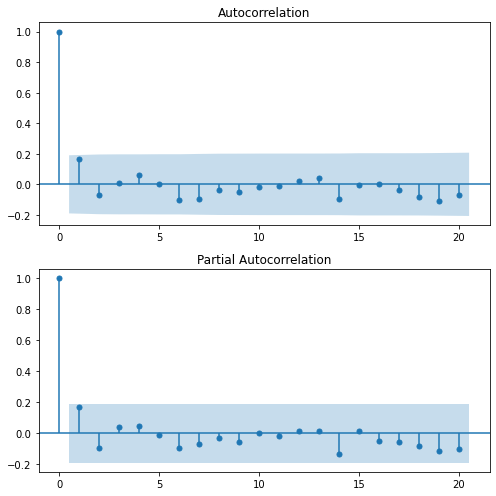

In [24]:
from statsmodels.tsa.stattools import acf, pacf
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

f, ax = plt.subplots(nrows=2, ncols=1, figsize=(7, 7))
plot_acf(df_serie['amount'],lags=20, ax=ax[0])
plot_pacf(df_serie['amount'],lags=20, ax=ax[1], method='ols')
plt.tight_layout()
plt.show()

### Planteamiento del Modelo

### Monto

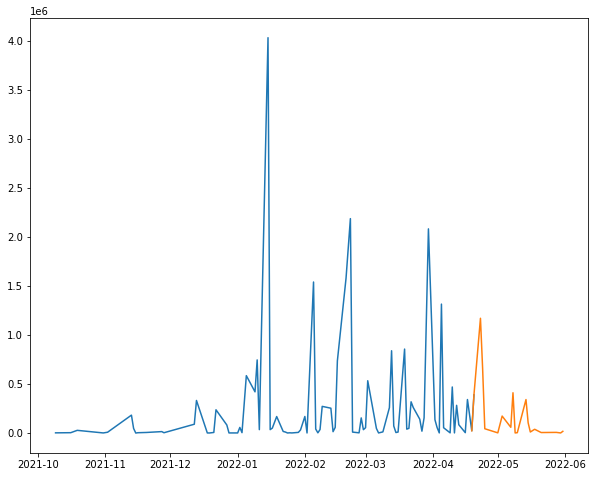

In [25]:
# particionar los datos de train y de test para el modelo
df_train = df_serie['amount'][:89]
df_test = df_serie['amount'][-19:]
plt.plot(df_train)
plt.plot(df_test)

#### AutoArima

In [26]:
from pmdarima import auto_arima
  
import warnings
warnings.filterwarnings("ignore")
  
arima_model = auto_arima(df_train,start_p = 0, start_q = 0,
                          max_p = 3, max_q = 3, m = 7,
                          start_P = 0, seasonal = True,
                          d = 1, D = 1, trace = True,
                          error_action ='ignore',  
                          suppress_warnings = True, 
                          stepwise = True)           
arima_model.summary()

Performing stepwise search to minimize aic
 ARIMA(0,1,0)(0,1,1)[7]             : AIC=2450.536, Time=0.17 sec
 ARIMA(0,1,0)(0,1,0)[7]             : AIC=2493.067, Time=0.01 sec
 ARIMA(1,1,0)(1,1,0)[7]             : AIC=2467.957, Time=0.07 sec
 ARIMA(0,1,1)(0,1,1)[7]             : AIC=2437.242, Time=0.06 sec
 ARIMA(0,1,1)(0,1,0)[7]             : AIC=inf, Time=0.05 sec
 ARIMA(0,1,1)(1,1,1)[7]             : AIC=2438.616, Time=0.17 sec
 ARIMA(0,1,1)(0,1,2)[7]             : AIC=2438.481, Time=0.28 sec
 ARIMA(0,1,1)(1,1,0)[7]             : AIC=2447.461, Time=0.07 sec
 ARIMA(0,1,1)(1,1,2)[7]             : AIC=2440.397, Time=0.42 sec
 ARIMA(1,1,1)(0,1,1)[7]             : AIC=2435.868, Time=0.08 sec
 ARIMA(1,1,1)(0,1,0)[7]             : AIC=inf, Time=0.08 sec
 ARIMA(1,1,1)(1,1,1)[7]             : AIC=2437.409, Time=0.14 sec
 ARIMA(1,1,1)(0,1,2)[7]             : AIC=2437.298, Time=0.15 sec
 ARIMA(1,1,1)(1,1,0)[7]             : AIC=2446.359, Time=0.12 sec
 ARIMA(1,1,1)(1,1,2)[7]             : AIC=2

<class 'statsmodels.iolib.summary.Summary'>
"""
                                     SARIMAX Results                                     
=========================================================================================
Dep. Variable:                                 y   No. Observations:                   89
Model:             SARIMAX(1, 1, 1)x(0, 1, 1, 7)   Log Likelihood               -1213.934
Date:                           Tue, 28 Jun 2022   AIC                           2435.868
Time:                                   10:15:30   BIC                           2445.445
Sample:                                        0   HQIC                          2439.710
                                            - 89                                         
Covariance Type:                             opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.1485      0.229      0.649      0.516      -0.300       0.597
ma.L1         -0.9324      0.213     -4.384      0.000      -1.349      -0.516
ma.S.L7       -0.7996      0.242     -3.303      0.001      -1.274      -0.325
sigma2      9.962e+11   1.58e-13    6.3e+24      0.000    9.96e+11    9.96e+11
===================================================================================
Ljung-Box (L1) (Q):                   0.01   Jarque-Bera (JB):               382.42
Prob(Q):                              0.93   Prob(JB):                         0.00
Heteroskedasticity (H):               0.50   Skew:                             2.47
Prob(H) (two-sided):                  0.08   Kurtosis:                        12.43
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
[2] Covariance matrix is singular or near-singular, with condition number 2.05e+40. Standard errors may be unstable.
"""

In [27]:
predic_val = pd.DataFrame(arima_model.predict(n_periods=19), index=df_test.index)
predic_val.columns = ['amount_Pred']
predic_val

,amount_Pred
paidAt,
2022-04-19,56322.188524
2022-04-20,327477.796458
2022-04-23,259670.671306
2022-04-24,380286.318485
2022-04-25,251044.102134
2022-05-01,152735.747849
2022-05-03,471792.980880
2022-05-07,70417.921163
2022-05-08,331563.364683


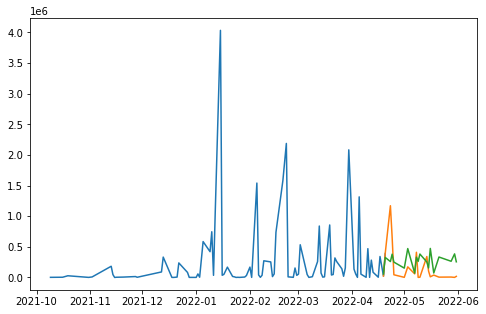

In [28]:
plt.figure(figsize=(8,5))
plt.plot(df_train,label="Training")
plt.plot(df_test,label="Test")
plt.plot(predic_val,label="Predicted")

#Graficar los montos reales y los que se predecidos
plt.show()

In [29]:
df_test.values

array([  23674.68,  390300.74, 1171308.8 ,  657567.27,   44358.7 ,
          2395.72,  173554.56,   59157.1 ,  411390.32,    1490.26,
          4077.98,  341978.06,  104623.1 ,   11004.22,   38941.18,
          5612.18,    7061.7 ,    1490.46,   18011.78])

In [30]:
predic_val['amount_Pred'].values

array([ 56322.18852352, 327477.79645785, 259670.67130567, 380286.31848497,
       251044.1021344 , 152735.7478487 , 471792.98088036,  70417.92116278,
       331563.36468273, 262269.46530118, 382664.28717555, 253389.27242537,
       155076.04670967, 474132.5562051 ,  72757.38902326, 333902.81658192,
       264608.91482969, 385003.73635195, 255728.72154948])

In [31]:
mae = metrics.mean_absolute_error(df_test.values, predic_val['amount_Pred'].values)
mse = metrics.mean_squared_error(df_test.values, predic_val['amount_Pred'].values)
rmse = np.sqrt(mse) 
r2 = metrics.r2_score(df_test.values, predic_val['amount_Pred'])

print("Metricas:")
print("MAE:",mae)
print("MSE:", mse)
print("RMSE:", rmse)
print("R-Squared:", r2)

Metricas:
MAE: 237534.79057478698
MSE: 99410684631.14131
RMSE: 315294.59974941105
R-Squared: -0.1384854473946331


In [32]:
# prediccion futuras
pred = arima_model.predict(start = len(df_serie), end = (df_serie)+60, typ='levels')

In [33]:
# crear el indice para los valores
index_fdates = pd.date_range(start='2022-04-19', end='2022-06-30')

In [34]:
predic_val = pd.DataFrame(arima_model.predict(n_periods=73), index=index_fdates)
predic_val.columns = ['amount_Pred']
predic_val

,amount_Pred
2022-04-19,56322.188524
2022-04-20,327477.796458
2022-04-21,259670.671306
2022-04-22,380286.318485
2022-04-23,251044.102134
...,...
2022-06-26,173791.639631
2022-06-27,492848.149125
2022-06-28,91472.981943
2022-06-29,352618.409502


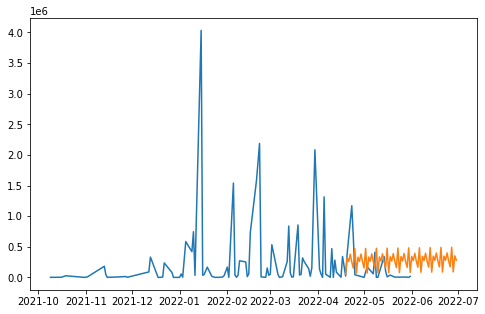

In [35]:
plt.figure(figsize=(8,5))
plt.plot(df_serie['amount'],label="Real")
plt.plot(predic_val,label="Pred")


#Graficar los montos reales y los que se predecidos
plt.show()

<AxesSubplot:>

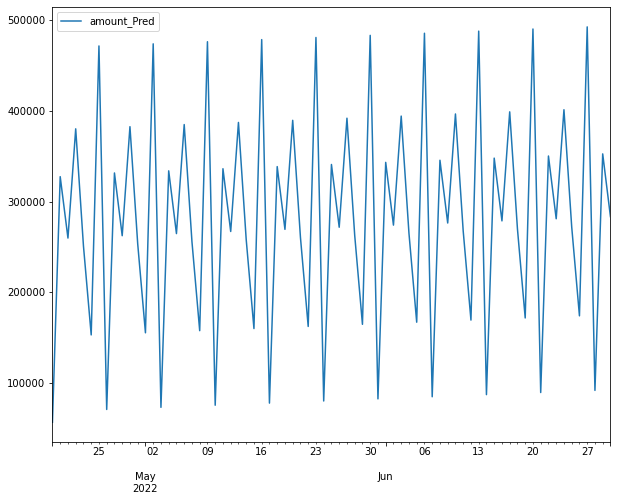

In [36]:
predic_val.plot()

A traves de ARIMA podemos ver que la prediccion es poco precisa por ello se recomienda tener mas cantidad de datos para mejorar el performance, tambien analizar como manejar esos valores en los que algunos dias no se tiene transacciones, aplicar otro modelo que se ajuste de manera mas adecuada.

#### XGBoost

In [37]:
from xgboost import XGBRegressor
import xgboost as xgb


In [38]:
# dividir los datos para train y test
def split_data(data, split_date):
    return data[data.index <= split_date].copy(), \
           data[data.index >  split_date].copy()
train, test = split_data(df_serie, '2022-04-20')

In [39]:
# eliminar la columna de monto financiado
test = test.drop(columns = 'amountFinanced')
train = train.drop(columns = 'amountFinanced')

In [40]:
def descomposicion_fechas(df):
    """
    Crea las descompocision de la fecha
    """
    df['date'] = df.index
    df['dayofweek'] = pd.DatetimeIndex(df['date']).dayofweek
    df['quarter'] = pd.DatetimeIndex(df['date']).quarter
    df['month'] = pd.DatetimeIndex(df['date']).month
    df['year'] = pd.DatetimeIndex(df['date']).year
    df['dayofyear'] = pd.DatetimeIndex(df['date']).dayofyear
    df['dayofmonth'] = pd.DatetimeIndex(df['date']).day
    df['weekofyear'] = pd.DatetimeIndex(df['date']).weekofyear
    
    X = df[['dayofweek','quarter','month','year',
           'dayofyear','dayofmonth','weekofyear']]
    return X

In [41]:
X_train, y_train = descomposicion_fechas(train), train['amount']
X_test, y_test   = descomposicion_fechas(test), test['amount']
X_train.shape, y_train.shape

((89, 7), (89,))

In [42]:
# ajustar el modelo XGBoost
reg = xgb.XGBRegressor(objective='reg:squarederror',n_estimators=1000)
reg.fit(X_train, y_train)

XGBRegressor(base_score=0.5, booster='gbtree', callbacks=None,
             colsample_bylevel=1, colsample_bynode=1, colsample_bytree=1,
             early_stopping_rounds=None, enable_categorical=False,
             eval_metric=None, gamma=0, gpu_id=-1, grow_policy='depthwise',
             importance_type=None, interaction_constraints='',
             learning_rate=0.300000012, max_bin=256, max_cat_to_onehot=4,
             max_delta_step=0, max_depth=6, max_leaves=0, min_child_weight=1,
             missing=nan, monotone_constraints='()', n_estimators=1000,
             n_jobs=0, num_parallel_tree=1, predictor='auto', random_state=0,
             reg_alpha=0, reg_lambda=1, ...)

<AxesSubplot:title={'center':'Feature importance'}, xlabel='F score', ylabel='Features'>

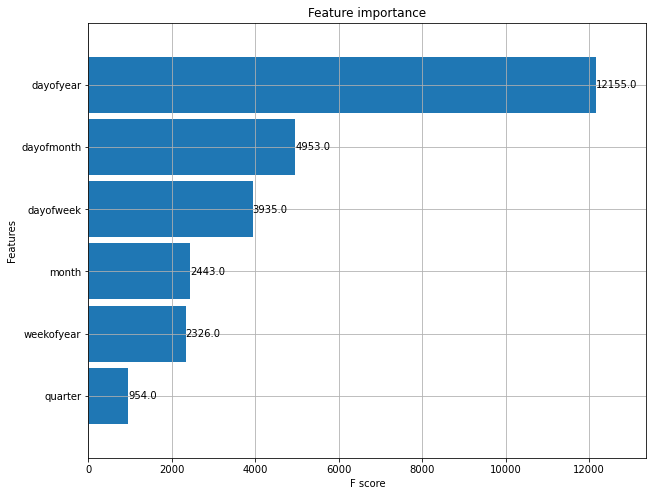

In [43]:
# variables importantes para el regresor
xgb.plot_importance(reg, height=0.9)

In [44]:
X_test_pred = reg.predict(X_test)

In [45]:
# calcular el error
mean_squared_error(y_true=y_test,
                   y_pred=X_test_pred)

283414422527.5651

In [46]:
# calcular el error absoluto
mean_absolute_error(y_true=y_test,
                   y_pred=X_test_pred)

366570.0929595588

Lo que podemos ver de igual manera que usando ARIMA se puede notar que es poco preciso pero mejor que AutoArima sin embargo para optimizar el modelo se tomaria las siguientes consideraciones:

- Utilizar mas datos para mejorar el performance
- Utilizar variables exogenas que permitan ayudar o identificar cierto patron que mejore el accuracy
- Utilizar hiperparametros para ayudar a mejorar al modelo
- Utilizar tecnicas como GridSearch.

### Monto Financiado

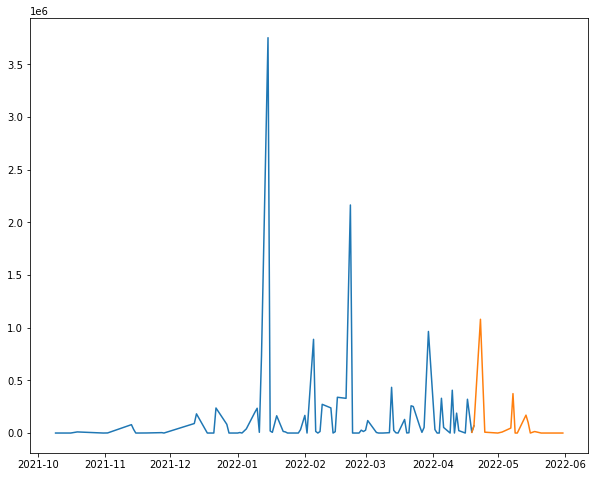

In [47]:
# particionar los datos de train y de test para el modelo
df_train = df_serie['amountFinanced'][:89]
df_test = df_serie['amountFinanced'][-19:]
plt.plot(df_train)
plt.plot(df_test)

#### AutoArima

In [48]:
from pmdarima import auto_arima
  
import warnings
warnings.filterwarnings("ignore")
  
arima_model = auto_arima(df_train,start_p = 0, start_q = 0,
                          max_p = 3, max_q = 3, m = 7,
                          start_P = 0, seasonal = True,
                          d = 1, D = 1, trace = True,
                          error_action ='ignore',  
                          suppress_warnings = True, 
                          stepwise = True)           
arima_model.summary()

Performing stepwise search to minimize aic
 ARIMA(0,1,0)(0,1,1)[7]             : AIC=inf, Time=0.12 sec
 ARIMA(0,1,0)(0,1,0)[7]             : AIC=2462.573, Time=0.02 sec
 ARIMA(1,1,0)(1,1,0)[7]             : AIC=2431.522, Time=0.07 sec
 ARIMA(0,1,1)(0,1,1)[7]             : AIC=2402.228, Time=0.09 sec
 ARIMA(0,1,1)(0,1,0)[7]             : AIC=inf, Time=0.07 sec
 ARIMA(0,1,1)(1,1,1)[7]             : AIC=2403.837, Time=0.12 sec
 ARIMA(0,1,1)(0,1,2)[7]             : AIC=2403.799, Time=0.18 sec
 ARIMA(0,1,1)(1,1,0)[7]             : AIC=2411.550, Time=0.11 sec
 ARIMA(0,1,1)(1,1,2)[7]             : AIC=2405.752, Time=0.43 sec
 ARIMA(1,1,1)(0,1,1)[7]             : AIC=2403.465, Time=0.09 sec
 ARIMA(0,1,2)(0,1,1)[7]             : AIC=2404.744, Time=0.12 sec
 ARIMA(1,1,0)(0,1,1)[7]             : AIC=2418.187, Time=0.09 sec
 ARIMA(1,1,2)(0,1,1)[7]             : AIC=2405.478, Time=0.36 sec
 ARIMA(0,1,1)(0,1,1)[7] intercept   : AIC=2404.704, Time=0.09 sec

Best model:  ARIMA(0,1,1)(0,1,1)[7]       

<class 'statsmodels.iolib.summary.Summary'>
"""
                                     SARIMAX Results                                     
=========================================================================================
Dep. Variable:                                 y   No. Observations:                   89
Model:             SARIMAX(0, 1, 1)x(0, 1, 1, 7)   Log Likelihood               -1198.114
Date:                           Tue, 28 Jun 2022   AIC                           2402.228
Time:                                   10:15:39   BIC                           2409.411
Sample:                                        0   HQIC                          2405.110
                                            - 89                                         
Covariance Type:                             opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ma.L1         -0.9177      0.220     -4.176      0.000      -1.348      -0.487
ma.S.L7       -0.8035      0.160     -5.021      0.000      -1.117      -0.490
sigma2      6.869e+11   2.54e-13   2.71e+24      0.000    6.87e+11    6.87e+11
===================================================================================
Ljung-Box (L1) (Q):                   0.58   Jarque-Bera (JB):              1883.93
Prob(Q):                              0.45   Prob(JB):                         0.00
Heteroskedasticity (H):               0.13   Skew:                             3.99
Prob(H) (two-sided):                  0.00   Kurtosis:                        25.24
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
[2] Covariance matrix is singular or near-singular, with condition number 2.74e+40. Standard errors may be unstable.
"""

In [49]:
predic_val = pd.DataFrame(arima_model.predict(n_periods=19), index=df_test.index)
predic_val.columns = ['amount_Pred']
predic_val

,amount_Pred
paidAt,
2022-04-19,-18203.419556
2022-04-20,169953.985265
2022-04-23,176227.410327
2022-04-24,64254.953660
2022-04-25,192559.608854
2022-05-01,27397.706419
2022-05-03,203156.367408
2022-05-07,-21767.343257
2022-05-08,166390.061564


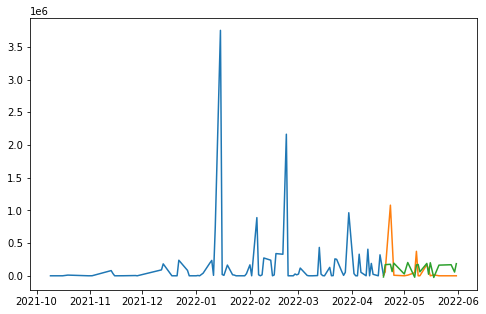

In [50]:
plt.figure(figsize=(8,5))
plt.plot(df_train,label="Training")
plt.plot(df_test,label="Test")
plt.plot(predic_val,label="Predicted")

#Graficar los montos reales y los que se predecidos
plt.show()

In [51]:
df_test.values

array([   6504.48,   68609.18, 1079751.14,  540023.98,    8024.41,
             0.  ,    9529.61,   47030.  ,  374279.37,       0.  ,
             0.  ,  169913.1 ,   99721.72,       0.  ,   14261.97,
             0.  ,       0.  ,       0.  ,       0.  ])

In [52]:
predic_val['amount_Pred'].values

array([-18203.41955636, 169953.98526495, 176227.41032659,  64254.95365969,
       192559.6088541 ,  27397.70641934, 203156.36740769, -21767.34325703,
       166390.06156428, 172663.48662592,  60691.02995901, 188995.68515343,
        23833.78271867, 199592.44370702, -25331.2669577 , 162826.1378636 ,
       169099.56292524,  57127.10625834, 185431.76145275])

In [53]:
mae = metrics.mean_absolute_error(df_test.values, predic_val['amount_Pred'].values)
mse = metrics.mean_squared_error(df_test.values, predic_val['amount_Pred'].values)
rmse = np.sqrt(mse) 
r2 = metrics.r2_score(df_test.values, predic_val['amount_Pred'])

print("Metricas:")
print("MAE:",mae)
print("MSE:", mse)
print("RMSE:", rmse)
print("R-Squared:", r2)

Metricas:
MAE: 175241.42438911932
MSE: 70927274266.78514
RMSE: 266321.7495188576
R-Squared: -0.008639388701311868


In [54]:
# prediccion futuras
pred = arima_model.predict(start = len(df_serie), end = (df_serie)+60, typ='levels')

In [55]:
# crear el indice para los valores
index_fdates = pd.date_range(start='2022-04-19', end='2022-06-30')

In [56]:
predic_val = pd.DataFrame(arima_model.predict(n_periods=73), index=index_fdates)
predic_val.columns = ['amount_Pred']
predic_val

,amount_Pred
2022-04-19,-18203.419556
2022-04-20,169953.985265
2022-04-21,176227.410327
2022-04-22,64254.953660
2022-04-23,192559.608854
...,...
2022-06-26,-4677.606887
2022-06-27,171081.054102
2022-06-28,-53842.656563
2022-06-29,134314.748258


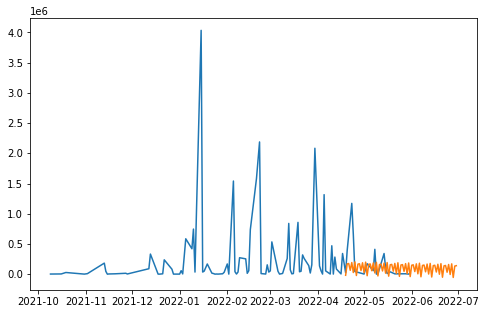

In [57]:
plt.figure(figsize=(8,5))
plt.plot(df_serie['amount'],label="Real")
plt.plot(predic_val,label="Pred")


#Graficar los montos reales y los que se predecidos
plt.show()

<AxesSubplot:>

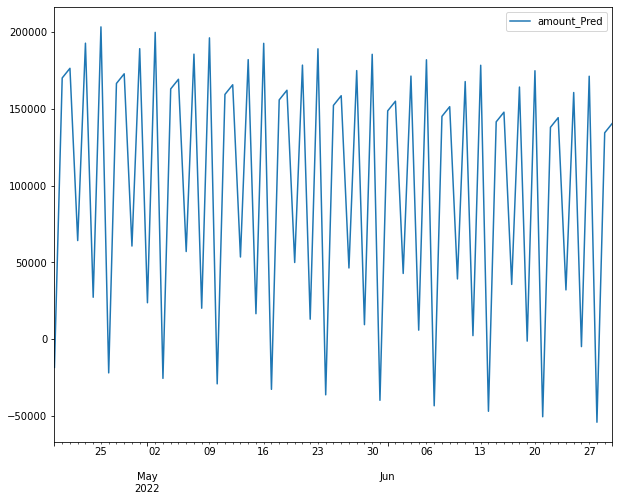

In [58]:
predic_val.plot()

A traves de ARIMA podemos ver que la prediccion es poco precisa por ello se recomienda tener mas cantidad de datos para mejorar el performance, tambien analizar como manejar esos valores en los que algunos dias no se tiene transacciones, aplicar otro modelo que se ajuste de manera mas adecuada.